In [ ]:
import paper_dataloaders
import paper_models

from seqdata.core import *
from seqdata.models.core import *
from seqdata.learner import *
from seqdata.dataloaders import *
from seqdata.dualrnn import *
from seqdata.hpopt import *
from fastai.basics import *
from fastai.callback.all import *
from seqdata.quaternions import *
from pathlib import Path
from ray import tune
import pickle

from paper_dataloaders import *
from paper_models import *

import ray
from ray import tune
from fastai.basics import *
import pandas as pd
%matplotlib widget

# Analyse the table

In [ ]:
ray.init() #auto is for attaching to a running local server
# ray.init() #auto is for attaching to a running local server


RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [ ]:
experiment_path = Path.home() / 'ray_results/FranSys_P4C_models'
# experiment_path = Path.home() / 'ray_results/archive/FranSys_P4C_models'
# experiment_path = Path.home() / 'hpc_data/ray_results/FranSys_P4C_models'

experiments = get_files(experiment_path,'.json').filter(lambda x: 'experiment_state' in x.name)
experiment_list = [tune.ExperimentAnalysis(e,default_metric='_rmse',default_mode='min') for e in experiments]
df = pd.concat([e.dataframe() for e in experiment_list],ignore_index=True)
group_clms = ['config/dl','config/size','config/pred_sz','config/schedule_pred','config/ablation']
df = df[df.training_iteration == 100].sort_values(group_clms)
trials = list(flatten([exp.trials for exp in experiment_list]))
df['trial'] = df.trial_id.apply(lambda t_id: first(trials, lambda y: y.trial_id == t_id))

2024-03-22 19:15:44,365	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 123 trial(s):
- learner_optimize_d3e1f_00242: FileNotFoundError('Could not fetch metrics for learner_optimize_d3e1f_00242: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4C_models/learner_optimize_d3e1f_00242_242_dl=Ship,pred_sz=60,size=medium_2024-03-16_05-09-42')
- learner_optimize_d3e1f_00243: FileNotFoundError('Could not fetch metrics for learner_optimize_d3e1f_00243: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4C_models/learner_optimize_d3e1f_00243_243_dl=Quadrotor,pred_sz=100,size=medium_2024-03-16_05-13-00')
- learner_optimize_d3e1f_00244: FileNotFoundError('Could not fetch metrics for learner_optimize_d3e1f_00244: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4C_models/learner_optimize_d3e1f_00244_244_dl=Robot,pred_sz=100,size=medium_2024-03-16_05-17-19')
- learner_op

In [ ]:
config = ['config/dl','config/size','config/pred_sz','config/schedule_pred']
experiment_path = Path.home() / 'ray_results/FranSys_P4B_models'
experiments = get_files(experiment_path,'.json').filter(lambda x: 'experiment_state' in x.name)
experiment_list = [tune.ExperimentAnalysis(e,default_metric='_rmse',default_mode='min') for e in experiments]
df_p4b = pd.concat([e.dataframe() for e in experiment_list],ignore_index=True)
df_p4b = df_p4b[df_p4b.training_iteration == 100].sort_values(config)
df_p4b['ablation'] = 'No Opt'

2024-03-22 19:15:46,742	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 123 trial(s):
- learner_optimize_a08f9_00389: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00389: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00389_389_dl=Ship,pred_sz=300,size=small_2024-03-19_09-43-43')
- learner_optimize_a08f9_00390: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00390: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00390_390_dl=Quadrotor,pred_sz=500,size=small_2024-03-19_09-46-04')
- learner_optimize_a08f9_00391: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00391: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00391_391_dl=Robot,pred_sz=500,size=small_2024-03-19_10-14-24')
- learner_opti

In [ ]:
df['ablation'] = df['config/ablation'].map({
    0: 'All Opt',
    1: 'State Sync',
    2: 'Diag Loss',
    3: 'continous tar'
})

df_cat = pd.concat([df[df['config/ablation'] == 0],df_p4b[(df_p4b['config/pred_sz'] <= 500)]]).sort_values(group_clms)
# df_cat=df_cat[df_cat['config/schedule_pred']]
# df_cat = pd.concat([df,df_p4b])

In [ ]:
important_colums = group_clms + ['_rmse']

In [ ]:
group_median = df.groupby(group_clms)['_rmse'].transform('median')
df['median_diff'] = (df['_rmse'] - group_median).abs()
# For each group, find the row with the minimum difference to the group's median _rmse value
df_med = df.loc[df.groupby(group_clms)['median_diff'].idxmin()]
# Optionally, you can drop the 'median_diff' column if you no longer need it
df_med = df_med.drop(columns=['median_diff'])
df_med['ablation'] = df_med['config/ablation'].map({
    0: 'No Opt',
    1: 'State Sync',
    2: 'Diag Loss',
    3: 'continous tar'
})
df_med[group_clms + ['_rmse']]

,config/dl,config/size,config/pred_sz,config/schedule_pred,config/ablation,_rmse
136,Quadrotor,large,60,False,0,0.239575
1741,Quadrotor,large,60,False,1,0.242444
1266,Quadrotor,large,60,False,2,0.238374
704,Quadrotor,large,60,True,0,0.242498
19,Quadrotor,large,100,False,0,0.295864
...,...,...,...,...,...,...
475,Ship,small,300,True,0,0.059455
643,Ship,small,500,False,0,0.095978
1439,Ship,small,500,False,1,0.094879
1800,Ship,small,500,False,2,0.101337


In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    'font.size': 13,
    'font.family': "Times New Roman"
})

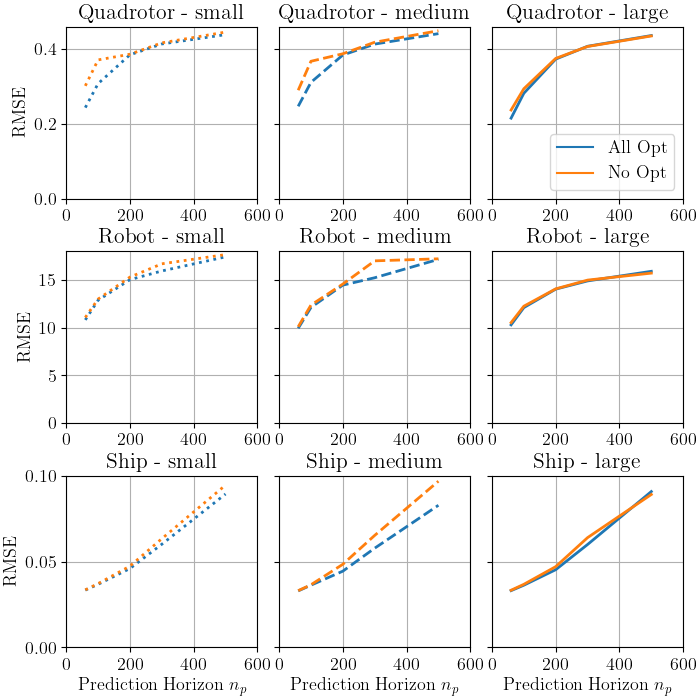

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
linestyles = {'small': ':', 'medium': '--', 'large': '-'}
sizes = ['small', 'medium', 'large']
df_plot=df_cat[~df_cat['config/schedule_pred']]
datasets = df_plot['config/dl'].unique()

for i, size in enumerate(sizes):
    for j, dataset in enumerate(datasets):
        # Filtering data for the current dataset and size
        df_subset = df_plot[(df_plot['config/dl'] == dataset) & (df_plot['config/size'] == size)]
        ax = axes[j, i]
        
        # Since seaborn's lineplot may not directly accept a 'dashes' parameter with a dictionary as we initially attempted,
        # we will apply the linestyles after plotting by accessing the lines drawn by seaborn and setting their linestyles.
        sns.lineplot(data=df_subset, x='config/pred_sz', y='_rmse', hue='ablation', ax=ax,errorbar=None,lw=2, estimator='min')
        
        # Setting line styles post-hoc
        lines = ax.get_lines()  # Get the lines that seaborn has plotted
        for line in lines:
            line.set_linestyle(linestyles[size])  # Set linestyle based on the model size
        
        ax.set_ylim(0)
        ax.legend().set_visible(False)  # Hide legend to avoid repetition
        ax.set_title(f"{dataset} - {size}")
        ax.set_xticks([0,200,400,600])
        ax.grid()
        if i > 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('RMSE')
        if j < 2:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Prediction Horizon $n_p$')
            
for idx_row in range(axes.shape[0]):
    y_max = max([ax.get_ylim()[-1] for ax in axes[idx_row,:]])
    for ax in axes[idx_row,:]:
        ax.set_ylim(0,y_max)
        
ax = axes[0, 2]
handles, labels = ax.get_legend_handles_labels()
#labels[1]='no reg'
#labels[0]='reg'
ax.legend(handles=handles, labels=labels,title=None, loc='lower right')

plt.tight_layout(pad=0.2)
plt.savefig('P4C_individual.pdf')

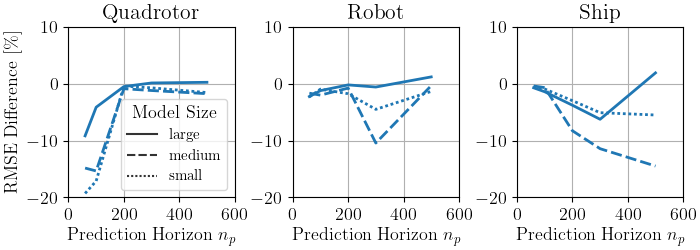

In [ ]:
# Adjusting the code to use seaborn lineplot for plotting

df_improvement = df_cat[~df_cat['config/schedule_pred']].copy()
df_improvement['schedule_pred_bool'] = df_improvement['ablation'].astype(str) != 'No Opt'

# Recalculate improvements with corrected boolean handling using median
rmse_improvement = df_improvement.groupby(['config/dl', 'config/size', 'config/pred_sz', 'schedule_pred_bool'])['_rmse'].min().unstack()
rmse_improvement_ratio = ((rmse_improvement[True] / rmse_improvement[False])-1)*100
rmse_improvement_ratio_reset = rmse_improvement_ratio.reset_index()
rmse_melted = rmse_improvement_ratio_reset.melt(id_vars=['config/dl', 'config/size', 'config/pred_sz'], value_name='Relative RMSE [%]', var_name='Metric')

fig, axes = plt.subplots(1, 3, figsize=(7, 2.5))

for i, dataset in enumerate(datasets):
    # RMSE Improvement Plot
    sns.lineplot(data=rmse_melted[rmse_melted['config/dl'] == dataset],lw=2,
                 x='config/pred_sz', y=r'Relative RMSE [%]', style='config/size', ax=axes[i])
    # axes[0, i].set_title(f"{dataset} - Relative RMSE")
    axes[i].set_title(f"{dataset}")
    axes[i].set_ylabel(r'RMSE Difference [\%]' if i == 0 else '')
    axes[i].set_xlabel(None)
    axes[i].set_xticks([0,200,400,600])
    axes[i].set_ylim(-20, 10)
    axes[i].set_xlabel('Prediction Horizon $n_p$')
    axes[i].legend().set_visible(False)  # Hide legend to avoid repetition
    axes[i].grid()

axes[0].legend(title='Model Size', loc='lower right',fontsize='small')

plt.tight_layout(pad=0.2)
plt.show()
plt.savefig('P4C_relative.pdf')